In [1]:
import adb
import image
from image import Image, Template, search
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv
import numpy as np
%matplotlib notebook

In [2]:
RED =      Template(image.read_image("red.png"))
HOR =      Template(image.read_image("hor.png"))
VERT =     Template(image.read_image("vert.png"))
HOR_ROT =  Template(image.read_image("hor_rot.png"))
VERT_ROT = Template(image.read_image("vert_rot.png"))
ROT =      Template(image.read_image("rot.png"))
OMNI =     Template(image.read_image("omni.png"))
OMNI_ROT = Template(image.read_image("omni_rot.png"))
CAN_ROTATE = ["rot", "vert_rot", "hor_rot", "omni_rot"]
CAN_SLIDE_HOR = ["hor", "hor_rot", "omni", "omni_rot"]
CAN_SLIDE_VERT = ["vert", "vert_rot", "omni", "omni_rot"]
CAN_SLIDE_OMNI = ["omni", "omni_rot"]
NAMED_TEMPLATES = {
    "red":      RED,
    "hor":      HOR,
    "vert":     VERT,
    "hor_rot":  HOR_ROT,
    "vert_rot": VERT_ROT,
    "rot":      ROT,
    "omni":     OMNI,
    "omni_rot": OMNI_ROT
}
UPPER_LEFT = (755,105)
UPPER_RIGHT = (755, 975)
LOWER_LEFT = (1615, 105)
LOWER_RIGHT = (1615, 975)
SPACING = (UPPER_RIGHT[1] - UPPER_LEFT[1]) / 5
X_BORDERS = range(UPPER_LEFT[1] - SPACING/2, UPPER_RIGHT[1] + SPACING, SPACING)
Y_BORDERS = range(UPPER_LEFT[0] - SPACING/2, LOWER_LEFT[0] + SPACING, SPACING)
PIXELS_PER_DASH = 25500


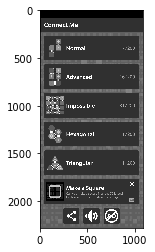

In [3]:
s = Image(adb.take_screenshot())
pairs = {
    RED:"red",
    OMNI: "green",
    OMNI_ROT: "orange",
    ROT: "blue",
    HOR_ROT: "peru",
    VERT_ROT: "brown",
    HOR: "purple",
    VERT: "pink"
}

f, a = plt.subplots(1, 1)
a.imshow(s.gray().im,cmap = "gray")
for template, color in pairs.items():
    coord = image.search_all(s, template, method = cv.TM_CCOEFF_NORMED, tolerance=0.9)
    for match in coord:
        print match["x"], match["y"], match["confidence"]
        a.add_patch(
            Rectangle(
                (match["x"] - 75, match["y"] - 75),
                150,
                150,
                fill = False,
                edgecolor = color,
                linewidth = 2
            ))


In [4]:
def count_white(im):
    top = Image(im).gray().im
    thresh = cv.threshold(top, 240, 255, cv.THRESH_BINARY)[1]
    return thresh.sum()

def get_dashes(cell_im):
    dashes = {}
    dashes["top"] = int(np.round(1.0*count_white(cell_im[5:15]) / PIXELS_PER_DASH))
    dashes["bot"] = int(np.round(1.0*count_white(cell_im[-15:-5]) / PIXELS_PER_DASH))
    dashes["left"] = int(np.round(1.0*count_white(cell_im[:,5:15]) / PIXELS_PER_DASH))
    dashes["right"] = int(np.round(1.0*count_white(cell_im[:,-15:-5]) / PIXELS_PER_DASH))
    return dashes

def get_type(cell_im):
    im = Image(cell_im)
    for name,template in NAMED_TEMPLATES.items():
        x,y,conf = image.search(im, template, method = cv.TM_CCOEFF_NORMED)
        if conf > 0.95:
            cell_type = name
            break
    else:
        cell_type = None
    return cell_type

def get_cell(s,i,j):
    return s[Y_BORDERS[i]:Y_BORDERS[i+1], X_BORDERS[j]:X_BORDERS[j+1]]

class Tile(object):
    def __init__(self, kind, dashes, i, j):
        self.type = kind
        self.top = dashes["top"]
        self.bot = dashes["bot"]
        self.left = dashes["left"]
        self.right = dashes["right"]
        self.i = i
        self.j = j
        self.viable_placements = None
        self.physical = None
        
    def __repr__(self):
        return "{:>8} {}{} {}{}{}{}".format(self.type, self.i, self.j, self.top, self.right, self.bot, self.left)
    
    def __eq__(self, other):
        return (
            self.i     == other.i and
            self.j     == other.j and
            self.type  == other.type and
            self.top   == other.top and
            self.bot   == other.bot and
            self.left  == other.left and
            self.right == other.right
        )
            
        
    def get_viable_locations(self):
        viable = set([(self.i, self.j)])
        if self.type in CAN_SLIDE_OMNI:
            viable.update([(i,j) for i in range(6) for j in range(6)])
        elif self.type in CAN_SLIDE_HOR:
            viable.update([(self.i,j) for j in range(6)])
        elif self.type in CAN_SLIDE_VERT:
            viable.update([(i,self.j) for i in range(6)])
        return viable
    
    def rotate(self, n = 1):
        if n == 0:
            return
        assert(self.type in CAN_ROTATE)
        self.top, self.right, self.bot, self.left = self.left, self.top, self.right, self.bot
        self.rotate(n-1)
        
    def copy(self):
        dashes = {"top":self.top, "bot": self.bot, "left": self.left, "right": self.right}
        return Tile(self.type, dashes, self.i, self.j)
        
    def get_viable_placements(self):
        self.physical = self.copy()
        viable = []
        if self.type in CAN_ROTATE:
            rotations_left = 3
        else:
            rotations_left = 0
        times_rotated = 0
        while rotations_left >= 0:
            dashes = {
                "top":self.top,
                "bot":self.bot,
                "left":self.left,
                "right":self.right
            }
            for i,j in self.get_viable_locations():
                viable.append(Tile(self.type, dashes, i,j))
            if rotations_left > 0:
                self.rotate()
                times_rotated += 1
            rotations_left -= 1
        if times_rotated > 0:
            self.rotate(4 - times_rotated) #reset
        self.viable_placements = viable
        return viable


00
0.0
0.0
0.0
0.6

01
0.66
0.0
0.59
1.57

02
0.2
0.0
0.88
1.04

03
0.15
0.0
0.0
0.0

04
0.0
0.0
0.0
0.0

05
0.0
0.0
0.0
0.0

10
0.0
0.39
0.0
0.4

11
0.0
3.64
0.55
1.79

12
0.0
7.77
1.64
1.14

13
0.0
1.73
1.8
0.0

14
0.0
0.0
0.0
0.0

15
0.0
0.0
0.0
0.0

20
0.7
0.0
0.0
0.6

21
1.2
0.0
0.7
1.06

22
0.0
0.0
0.14
0.15

23
0.0
0.0
0.17
0.0

24
0.0
0.0
0.0
0.0

25
0.0
0.0
0.0
0.0

30
0.0
0.05
0.0
0.99

31
0.0
0.0
0.8
1.39

32
0.0
0.0
1.25
1.78

33
0.0
0.0
1.03
0.0

34
0.0
0.0
0.0
0.0

35
0.0
0.0
0.0
0.0

40
0.0
0.0
0.0
0.0

41
0.0
0.0
0.0
0.0

42
0.0
0.0
0.0
0.0

43
0.0
0.0
0.0
0.0

44
0.0
0.0
0.0
0.0

45
0.0
0.0
0.0
0.0

50
0.0
0.0
0.0
1.38

51
0.0
0.0
0.37
1.39

52
0.0
0.0
1.2
0.61

53
0.0
0.0
0.39
0.0

54
0.0
0.0
0.0
0.0

55
0.0
0.0
0.0
0.0


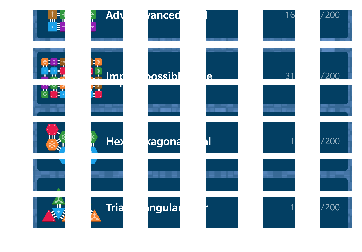

In [5]:
def get_dashes_verbose(cell_im):
    dashes = {}
    
    print float(count_white(cell_im[5:15]))/ PIXELS_PER_DASH
    print float(count_white(cell_im[-15:-5]))/ PIXELS_PER_DASH
    print float(count_white(cell_im[:,5:15]))/ PIXELS_PER_DASH
    print float(count_white(cell_im[:,-15:-5]))/ PIXELS_PER_DASH
    
    dashes["top"] = int(np.round(count_white(cell_im[5:15]) / PIXELS_PER_DASH))
    dashes["bot"] = int(np.round(count_white(cell_im[-15:-5]) / PIXELS_PER_DASH))
    dashes["left"] = int(np.round(count_white(cell_im[:,5:15]) / PIXELS_PER_DASH))
    dashes["right"] = int(np.round(count_white(cell_im[:,-15:-5]) / PIXELS_PER_DASH))
    return dashes

s = adb.take_screenshot()
fig, axes = plt.subplots(6, 6)
tiles = []
for i in range(6):
    for j in range(6):
        cell = get_cell(s, i, j)
        axes[i][j].imshow(cell[:,:,(2, 1, 0)])
        axes[i][j].axis("off")
#         Image(cell).show(width = 1, height = 1)
        print "\n{}{}".format(i,j)
        dashes = get_dashes_verbose(cell)
        kind = get_type(cell)
        if kind is not None:
            tiles.append(Tile(kind, dashes, i, j))
            

In [6]:
class State(object):
    def __init__(self, tiles):
        self.tiles = tiles
        self.map = {}
        self.log = {}
        
    def solve(self):
        self.determine_viable_placements()
        self.order_tiles()
        seed = self.tiles[0]
        for tile in seed.viable_placements:
            key = tile.i, tile.j
            self.map[key] = tile
            self.log[0] = key
            if self.loop():
                break
            else:
                self.map.pop(key)
                self.log.pop(0)
            
        
    def loop(self):
        assert(len(self.map) == len(self.log))
        loc = self.get_next_loc()
        if loc == (-1,-1):
            return self.check_solved()
        for i, tile in enumerate(self.tiles):
            if i in self.log:
                continue
            for t in tile.viable_placements:
                if self.check_move(loc, t):
                    key = t.i, t.j
                    assert key not in self.map
                    assert i not in self.log
                    self.map[key] = t
                    self.log[i] = key
                    if self.loop():
                        return True
                    else:
                        self.map.pop(key)
                        self.log.pop(i)
        return False
            
        
    def check_move(self, loc, tile):
        i,j = loc
        if tile.i != i or tile.j != j:
            return False
        if (
            i == 0 and tile.top > 0 or 
            i == 5 and tile.bot > 0 or 
            j == 0 and tile.left > 0 or 
            j == 5 and tile.right > 0
        ):
            return False
        if (i-1,j) in self.map:
            if tile.top != self.map[(i-1,j)].bot:
                return False
        if (i+1,j) in self.map:
            if tile.bot != self.map[(i+1,j)].top:
                return False
        if (i,j-1) in self.map:
            if tile.left != self.map[(i,j-1)].right:
                return False
        if (i,j+1) in self.map:
            if tile.right != self.map[(i,j+1)].left:
                return False
        return True
    

    def check_solved(self):
        return len(self.log) == len(self.tiles)
        
    def get_next_loc(self):
        for loc, tile in self.map.items():
            i,j = loc
            if tile.top > 0 and (i-1,j) not in self.map:
                return (i-1,j)
            if tile.bot > 0 and (i+1,j) not in self.map:
                return (i+1,j)
            if tile.right > 0 and (i,j+1) not in self.map:
                return (i,j+1)
            if tile.left > 0 and (i,j-1) not in self.map:
                return (i,j-1)
        return (-1,-1)
        
    def determine_viable_placements(self):
        for tile in self.tiles:
            tile.get_viable_placements()
            
    def order_tiles(self):
        self.tiles = sorted(self.tiles, key = lambda x: len(x.viable_placements))

In [7]:
def state_from_screen():
    s = adb.take_screenshot()
#     fig, axes = plt.subplots(6, 6)
    tiles = []
    for i in range(6):
        for j in range(6):
            cell = get_cell(s, i, j)
#             axes[i][j].imshow(cell[:,:,(2, 1, 0)])
#             axes[i][j].axis("off")
    #         Image(cell).show(width = 1, height = 1)
            dashes = get_dashes(cell)
            kind = get_type(cell)
            if kind is not None:
                tiles.append(Tile(kind, dashes, i, j))
    return State(tiles)

# push solution

In [8]:
from time import sleep
import sys

def drag(c1, c2):
    x1 = X_BORDERS[c1[1]] + SPACING / 2
    y1 = Y_BORDERS[c1[0]] + SPACING / 2
    x2 = X_BORDERS[c2[1]] + SPACING / 2
    y2 = Y_BORDERS[c2[0]] + SPACING / 2
    return adb.swipe(x1, y1, x2, y2, 250)

def rotate(c):
    x = X_BORDERS[c[1]] + SPACING / 2
    y = Y_BORDERS[c[0]] + SPACING / 2
    return adb.tap(x, y)

def how_many_rotations(tile1, tile2):
    """
    The number of times tile1 needs to be rotated to be equal to tile2
    """
    cycle1 = [tile1.top, tile1.right, tile1.bot, tile1.left]
    cycle2 = [tile2.top, tile2.right, tile2.bot, tile2.left]
    rotations = 0
    while cycle1 != cycle2:
        cycle1.insert(0, cycle1.pop())
        rotations += 1
        if rotations >= 4:
            return -1
    return rotations
    
def execute_solution(solved):
    
    placed = {key : False for key in solved.map}
    while not all(placed.values()):
        try:
            live = state_from_screen()
            live.map = {(tile.i, tile.j) : tile for tile in live.tiles}
            empty_mask = np.ones((6,6))
            for loc in live.map:
                empty_mask[loc] = 0
            for loc in placed:
                print "\rplaced {:2d} of {:2d}".format(sum(placed.values()), len(placed)),
                sys.stdout.flush()
                if placed[loc]:
                    continue
                solved_tile = solved.map[loc]
                if loc in live.map:
                    if live.map[loc] == solved_tile:
                        placed[loc] = True
                        continue
                    #check to see if it is the right tile but wrong rotation
                    if any([tile == solved_tile for tile in live.map[loc].get_viable_placements()]):
                        rotations = how_many_rotations(live.map[loc], solved_tile)
                        if rotations > 0:
                            for k in range(rotations):
                                rotate(loc)
                                live.map[loc].rotate()
                                sleep(0.5)
                            continue
                    else:
                        #move tile away
                        for tile in live.map[loc].get_viable_placements():
                            if empty_mask[tile.i, tile.j]:
                                drag(loc, (tile.i, tile.j))
                                sleep(0.5)
                                live.map[(tile.i, tile.j)] = live.map.pop(loc)
                                empty_mask[tile.i, tile.j] = 0
                for tile in live.tiles:
                    for _tile in tile.get_viable_placements():
                        if solved_tile == _tile:
                            #match found
                            if tile.i != solved_tile.i or tile.j != solved_tile.j:
                                drag((tile.i, tile.j), (solved_tile.i, solved_tile.j))
                                empty_mask[(solved_tile.i, solved_tile.j)] = 0
                                live.map[(solved_tile.i, solved_tile.j)] = live.map.pop((tile.i, tile.j))
                                sleep(0.5)
                            rotations = how_many_rotations(tile, solved_tile)
                            assert(rotations > -1)
                            for k in range(rotations):
                                rotate((solved_tile.i, solved_tile.j))
                                sleep(0.5)
                            break
                    else:
                        continue
                    break
        except KeyError:
#             print "\nkey error"
            continue
#             break
    print "\rplaced {:2d} of {:2d}".format(sum(placed.values()), len(placed)),
            
                    
                
        
        
        

In [9]:
state = state_from_screen()
state.solve()
execute_solution(state)

placed 22 of 22                                                                               
